In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

In [3]:
#train
train=data('/kaggle/input/bone-fracture/dataset/train')
train.head()

image          label
0  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
1  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
2  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
3  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured
4  /kaggle/input/bone-fracture/dataset/train/not ...  not fractured

In [4]:
#test
test=data('/kaggle/input/bone-fracture/dataset/test')
test.head()

image          label
0  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
1  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
2  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
3  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured
4  /kaggle/input/bone-fracture/dataset/test/not f...  not fractured

In [5]:
#val
val=data('/kaggle/input/bone-fracture/dataset/val')
val.head()

image          label
0  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
1  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
2  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
3  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured
4  /kaggle/input/bone-fracture/dataset/val/not fr...  not fractured

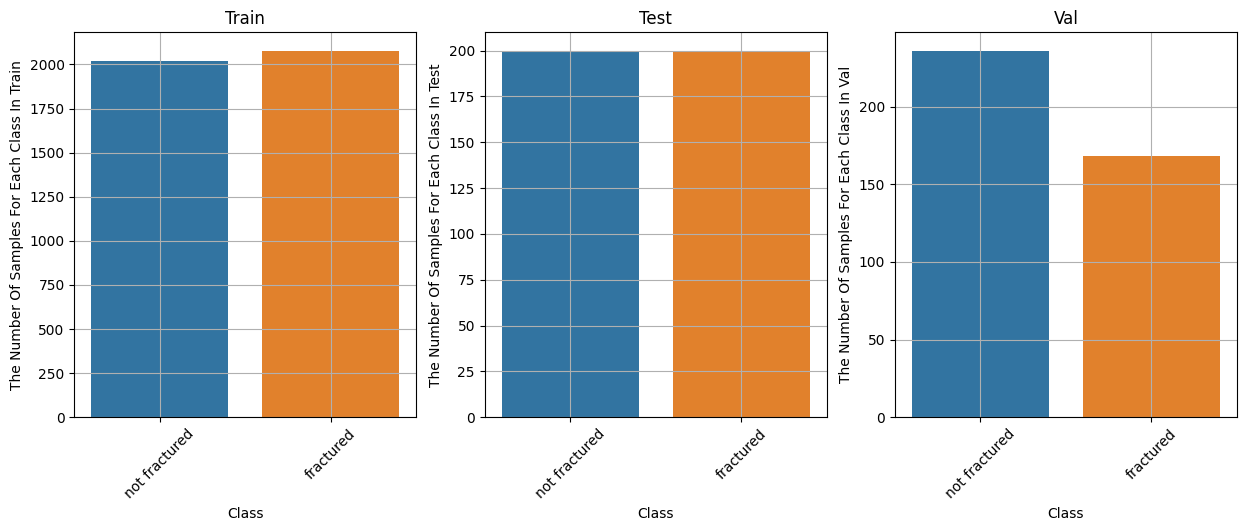

In [6]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
ax = sns.countplot(x=train.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,2)
ax = sns.countplot(x=test.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
plt.subplot(1,3,3)
ax = sns.countplot(x=val.label)
ax.set_xlabel("Class")
ax.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

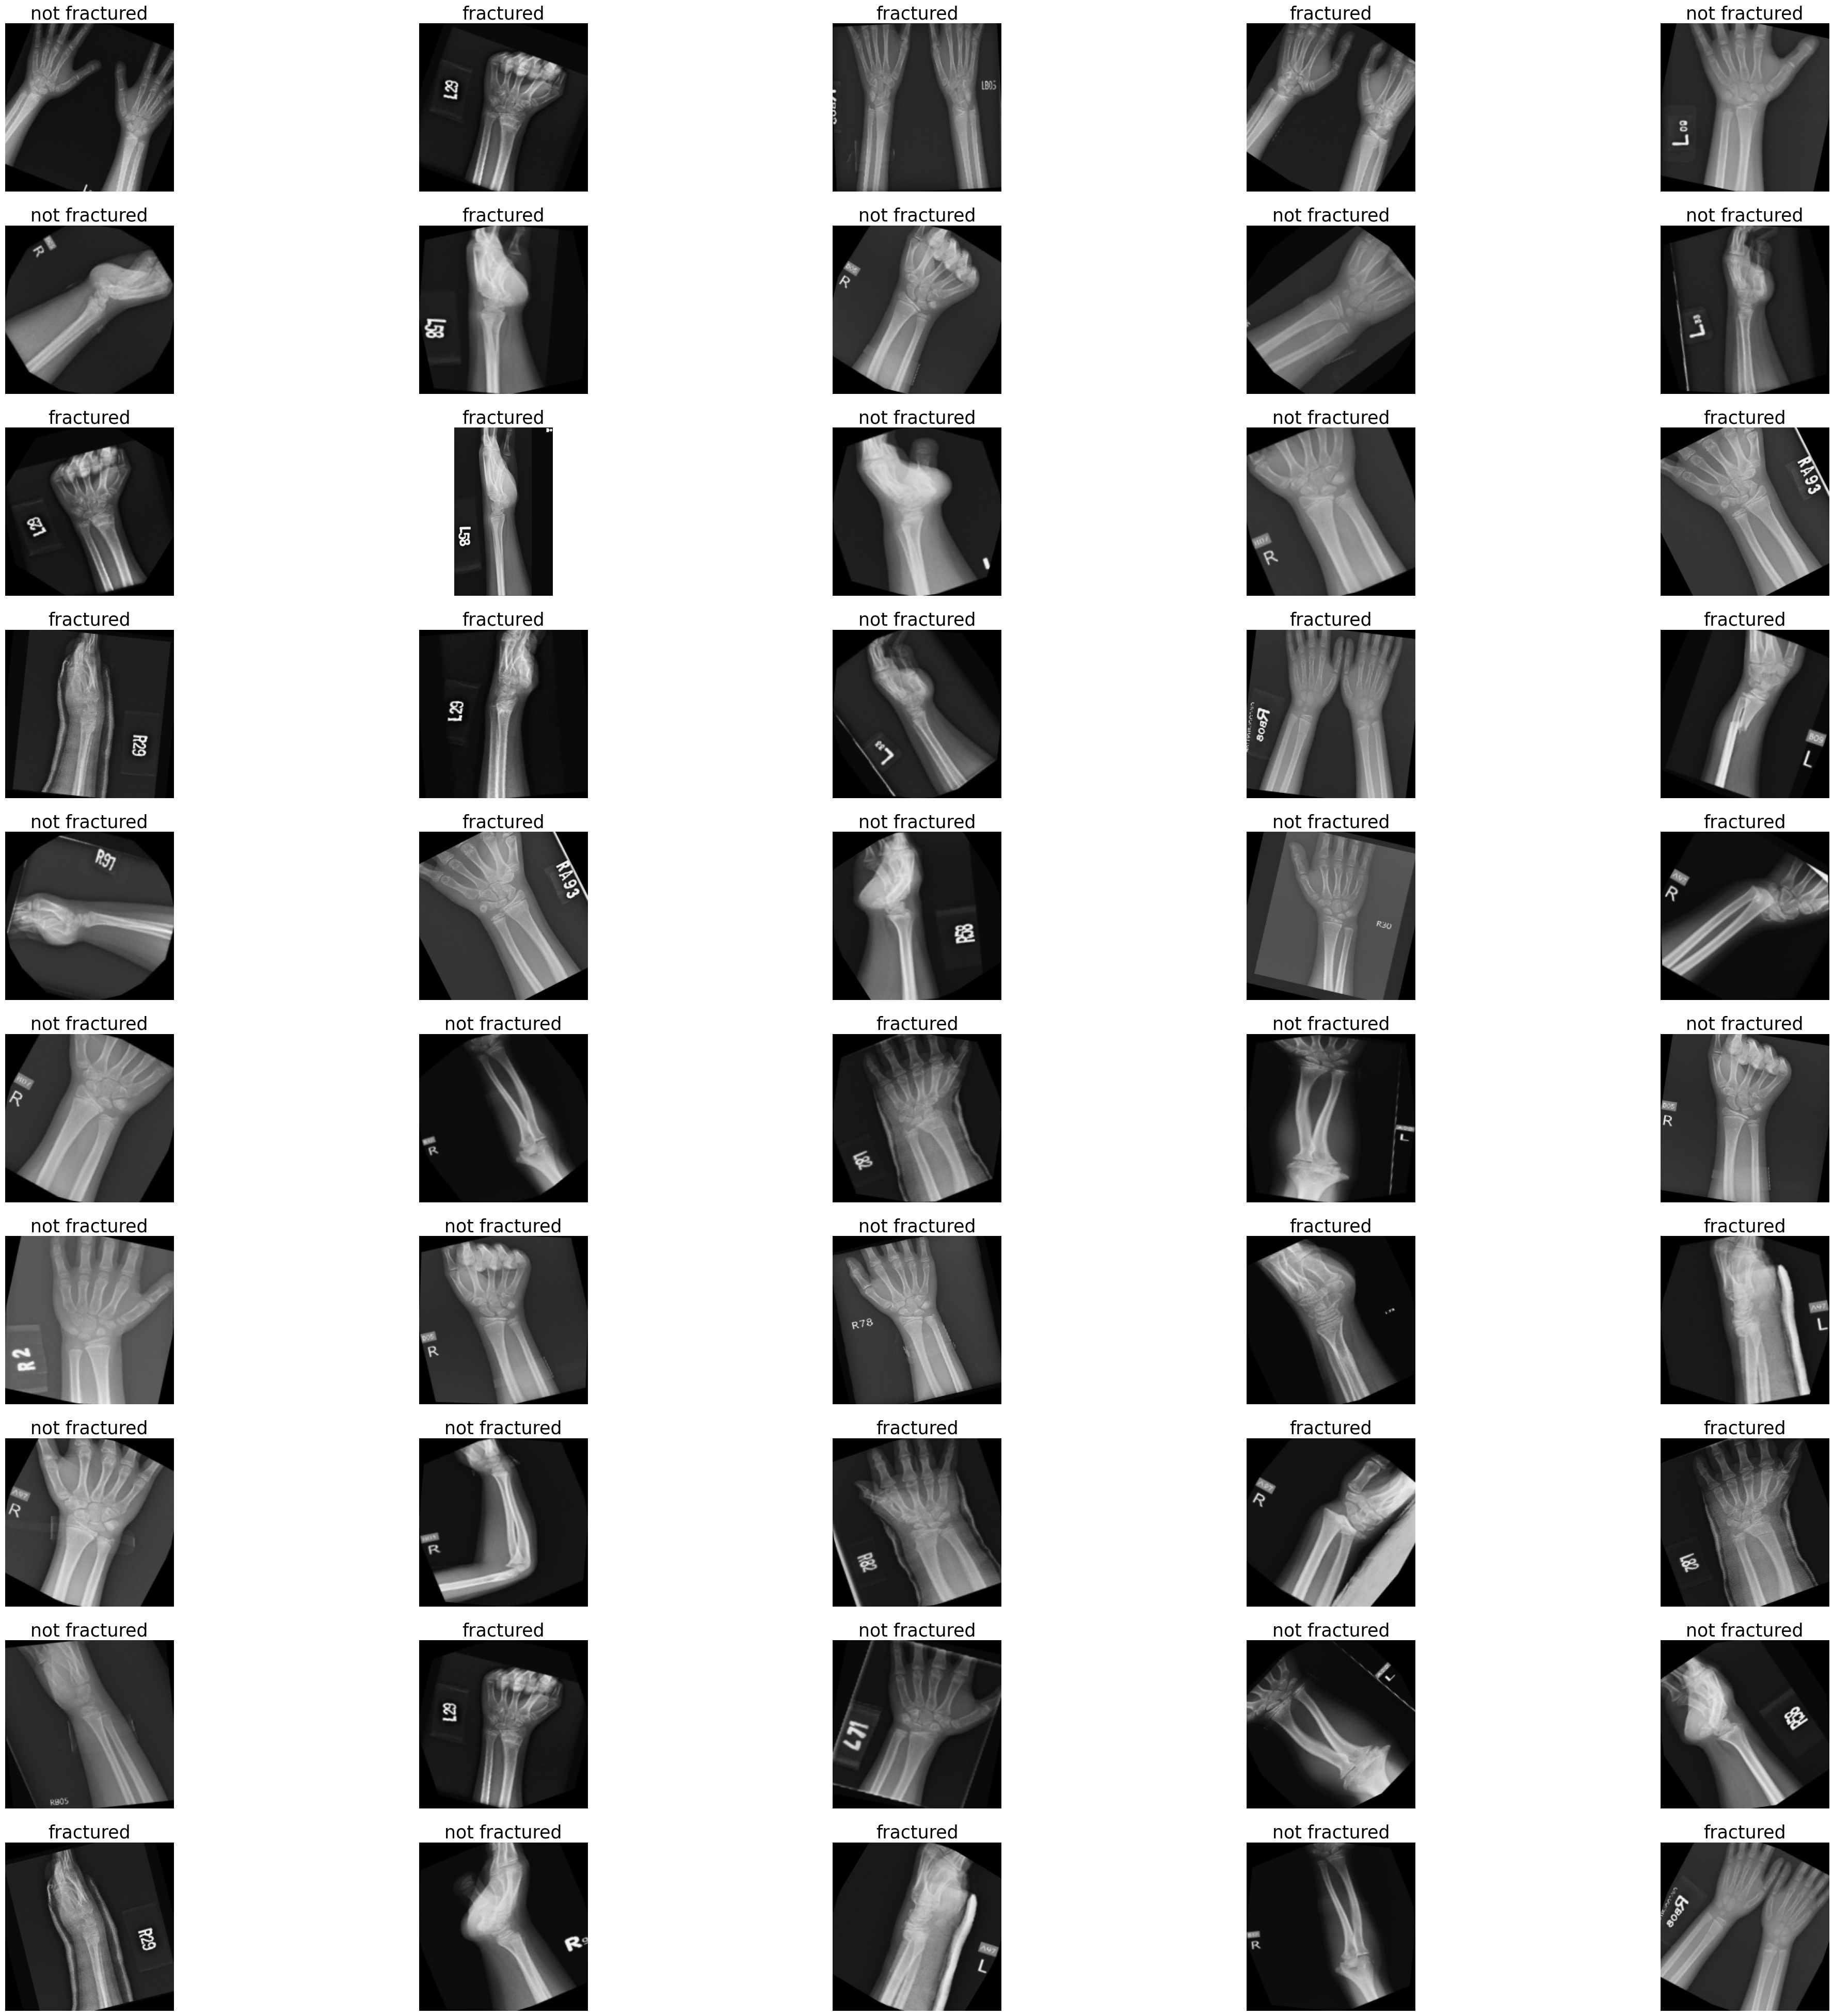

In [7]:
plt.figure(figsize=(50,50))
for n,i in enumerate(np.random.randint(0,len(train),50)):
    plt.subplot(10,5,n+1)
    img=cv2.imread(train.image[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i],fontsize=25)

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


In [9]:
class_num=1
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2)))  
model.add(keras.layers.Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu)) 
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.MaxPool2D((2,2))) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256,activation=tf.nn.relu))
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(128,activation=tf.nn.relu)) 
model.add(keras.layers.Dropout(.3)) 
model.add(keras.layers.Dense(class_num,activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256       
 hNormalization)                                                 
                                                        

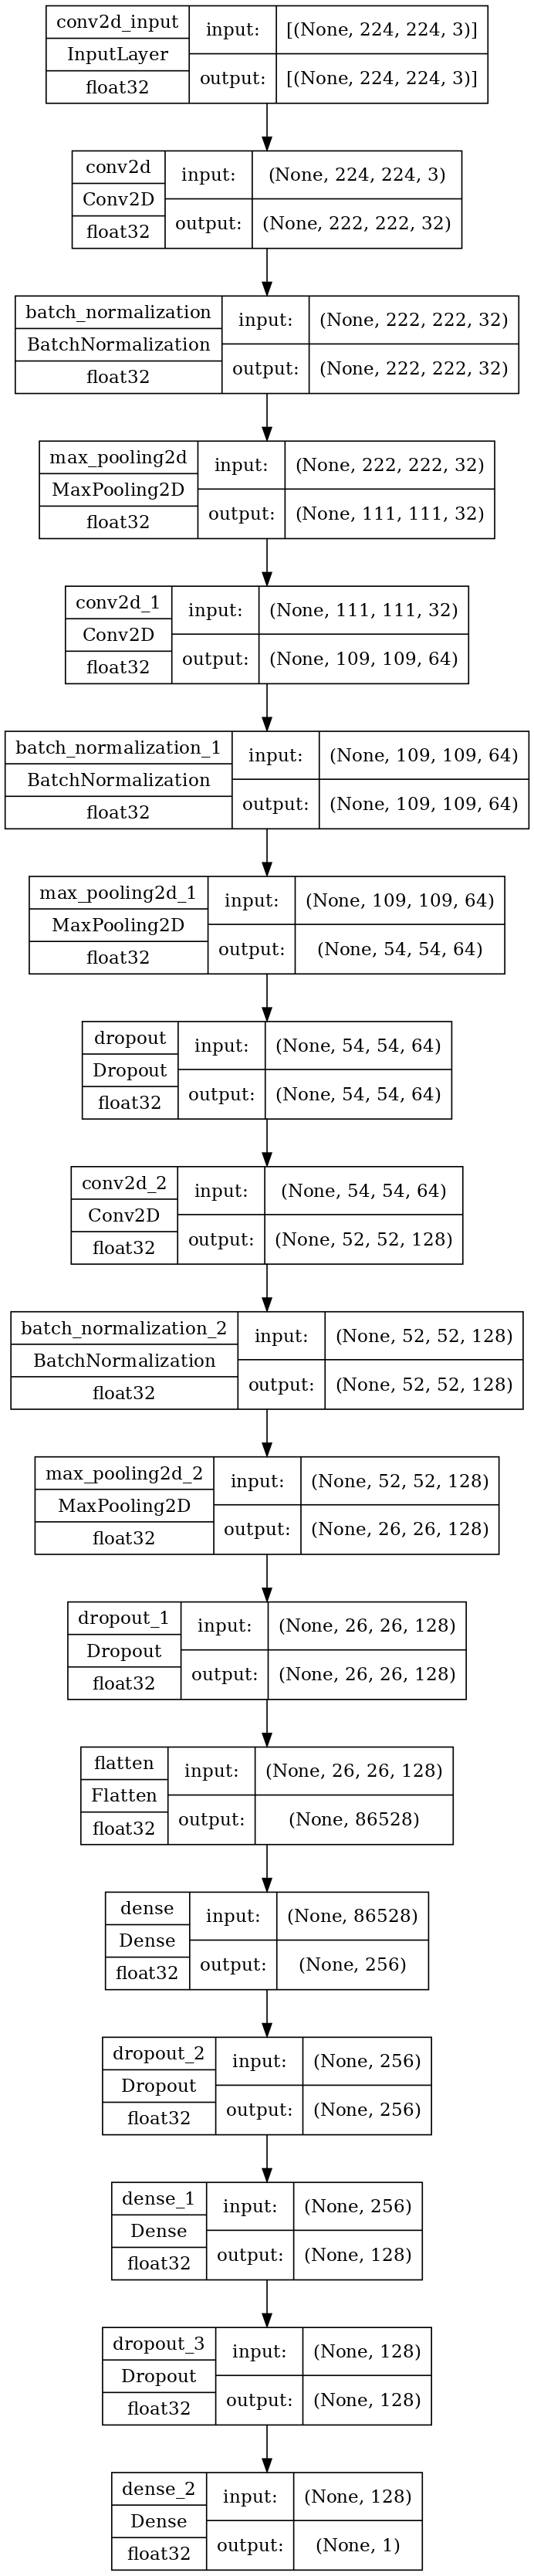

In [10]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=120)

In [11]:
checkpoint_cb =ModelCheckpoint("my_keras_model.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer ='adam', loss='binary_crossentropy', metrics=['accuracy',keras.metrics.SpecificityAtSensitivity(0.5),keras.metrics.AUC()])
hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])

/tmp/ipykernel_20/4118689137.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist=model.fit_generator(train_generator,epochs=10,validation_data=val_generator,callbacks=[checkpoint_cb,early_stopping_cb])


Epoch 1/10
129/129 [==============================] - 371s 3s/step - loss: 3.0338 - accuracy: 0.7127 - specificity_at_sensitivity: 0.8349 - auc: 0.7531 - val_loss: 16.3048 - val_accuracy: 0.5842 - val_specificity_at_sensitivity: 0.0000e+00 - val_auc: 0.5000
Epoch 2/10
129/129 [==============================] - 365s 3s/step - loss: 0.7668 - accuracy: 0.8428 - specificity_at_sensitivity: 0.9519 - auc: 0.9071 - val_loss: 15.8439 - val_accuracy: 0.5842 - val_specificity_at_sensitivity: 0.0000e+00 - val_auc: 0.5000
Epoch 3/10
129/129 [==============================] - 365s 3s/step - loss: 0.3934 - accuracy: 0.8958 - specificity_at_sensitivity: 0.9779 - auc: 0.9513 - val_loss: 6.1651 - val_accuracy: 0.6832 - val_specificity_at_sensitivity: 0.3631 - val_auc: 0.6346
Epoch 4/10
129/129 [==============================] - 366s 3s/step - loss: 0.1926 - accuracy: 0.9378 - specificity_at_sensitivity: 0.9918 - auc: 0.9808 - val_loss: 4.7915 - val_accuracy: 0.7203 - val_specificity_at_sensitivity: 0.4

In [12]:
hist_=pd.DataFrame(hist.history)
hist_

loss  accuracy  specificity_at_sensitivity       auc   val_loss  \
0  3.033822  0.712717                    0.834937  0.753091  16.304750   
1  0.766776  0.842812                    0.951877  0.907132  15.843904   
2  0.393441  0.895777                    0.977863  0.951256   6.165103   
3  0.192611  0.937759                    0.991819  0.980822   4.791451   
4  0.186395  0.935319                    0.993263  0.982258   0.423668   
5  0.176331  0.945326                    0.993263  0.983877   0.049991   
6  0.148779  0.952892                    0.997113  0.987861   0.076168   
7  0.143162  0.951916                    0.997594  0.988008   0.213242   
8  0.153500  0.962167                    0.992300  0.987018   0.021819   
9  0.120969  0.964852                    0.995669  0.991425   0.169552   

   val_accuracy  val_specificity_at_sensitivity   val_auc  
0      0.584158                        0.000000  0.500000  
1      0.584158                        0.000000  0.500000  
2      0.683168                        0.363095  0.634647  
3      0.720297                        0.446429  0.669744  
4      0.861386                        0.958333  0.951095  
5      0.980198                        1.000000  0.998562  
6      0.970297                        1.000000  0.996772  
7      0.933168                        0.976190  0.975636  
8      0.990099                        1.000000  0.999924  
9      0.957921                        1.000000  0.987477

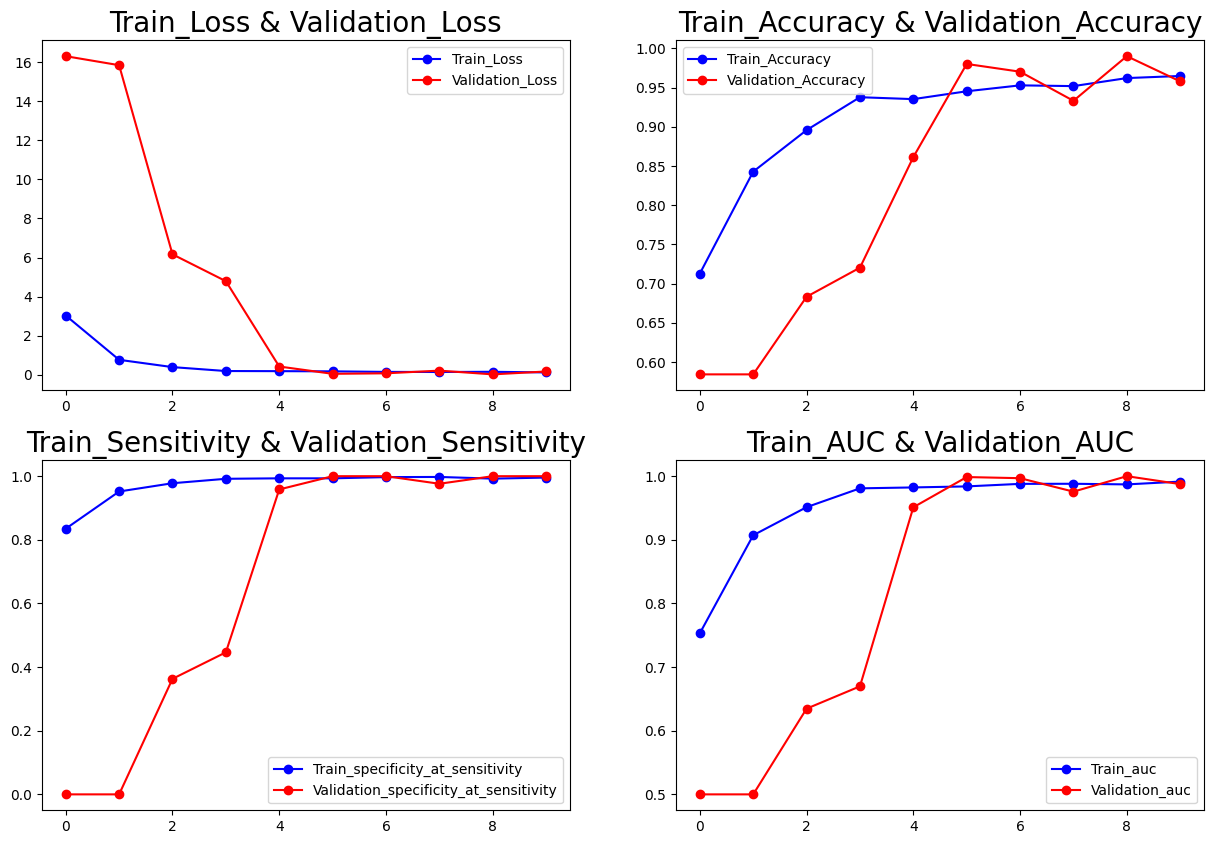

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.plot(hist_['loss'],'b-o',label='Train_Loss')
plt.plot(hist_['val_loss'],'r-o',label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist_['accuracy'],'b-o',label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],'r-o',label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()
plt.subplot(2,2,3)
plt.plot(hist_['specificity_at_sensitivity'],'b-o',label='Train_specificity_at_sensitivity')
plt.plot(hist_['val_specificity_at_sensitivity'],'r-o',label='Validation_specificity_at_sensitivity')
plt.title('Train_Sensitivity & Validation_Sensitivity',fontsize=20)
plt.legend()
plt.subplot(2,2,4)
plt.plot(hist_['auc'],'b-o',label='Train_auc')
plt.plot(hist_['val_auc'],'r-o',label='Validation_auc')
plt.title('Train_AUC & Validation_AUC',fontsize=20)
plt.legend()
plt.show()

In [14]:
score, acc,sensitivity,auc = model.evaluate(test_generator)
print('Test Loss =', score)
print('Test Accuracy =', acc)
print('Test Sensitivity =', sensitivity)
print('Test AUC =', auc)

13/13 [==============================] - 10s 749ms/step - loss: 0.1785 - accuracy: 0.9499 - specificity_at_sensitivity: 1.0000 - auc: 0.9875
Test Loss = 0.1785418838262558
Test Accuracy = 0.9498746991157532
Test Sensitivity = 1.0
Test AUC = 0.9874623417854309


In [15]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)
df = pd.DataFrame({'Actual': y_test, 'Prediction': y_pred})
df

13/13 [==============================] - 9s 697ms/step


Actual  Prediction
0         1           1
1         1           1
2         1           1
3         1           1
4         1           1
..      ...         ...
394       0           0
395       0           0
396       0           0
397       0           0
398       0           0

[399 rows x 2 columns]

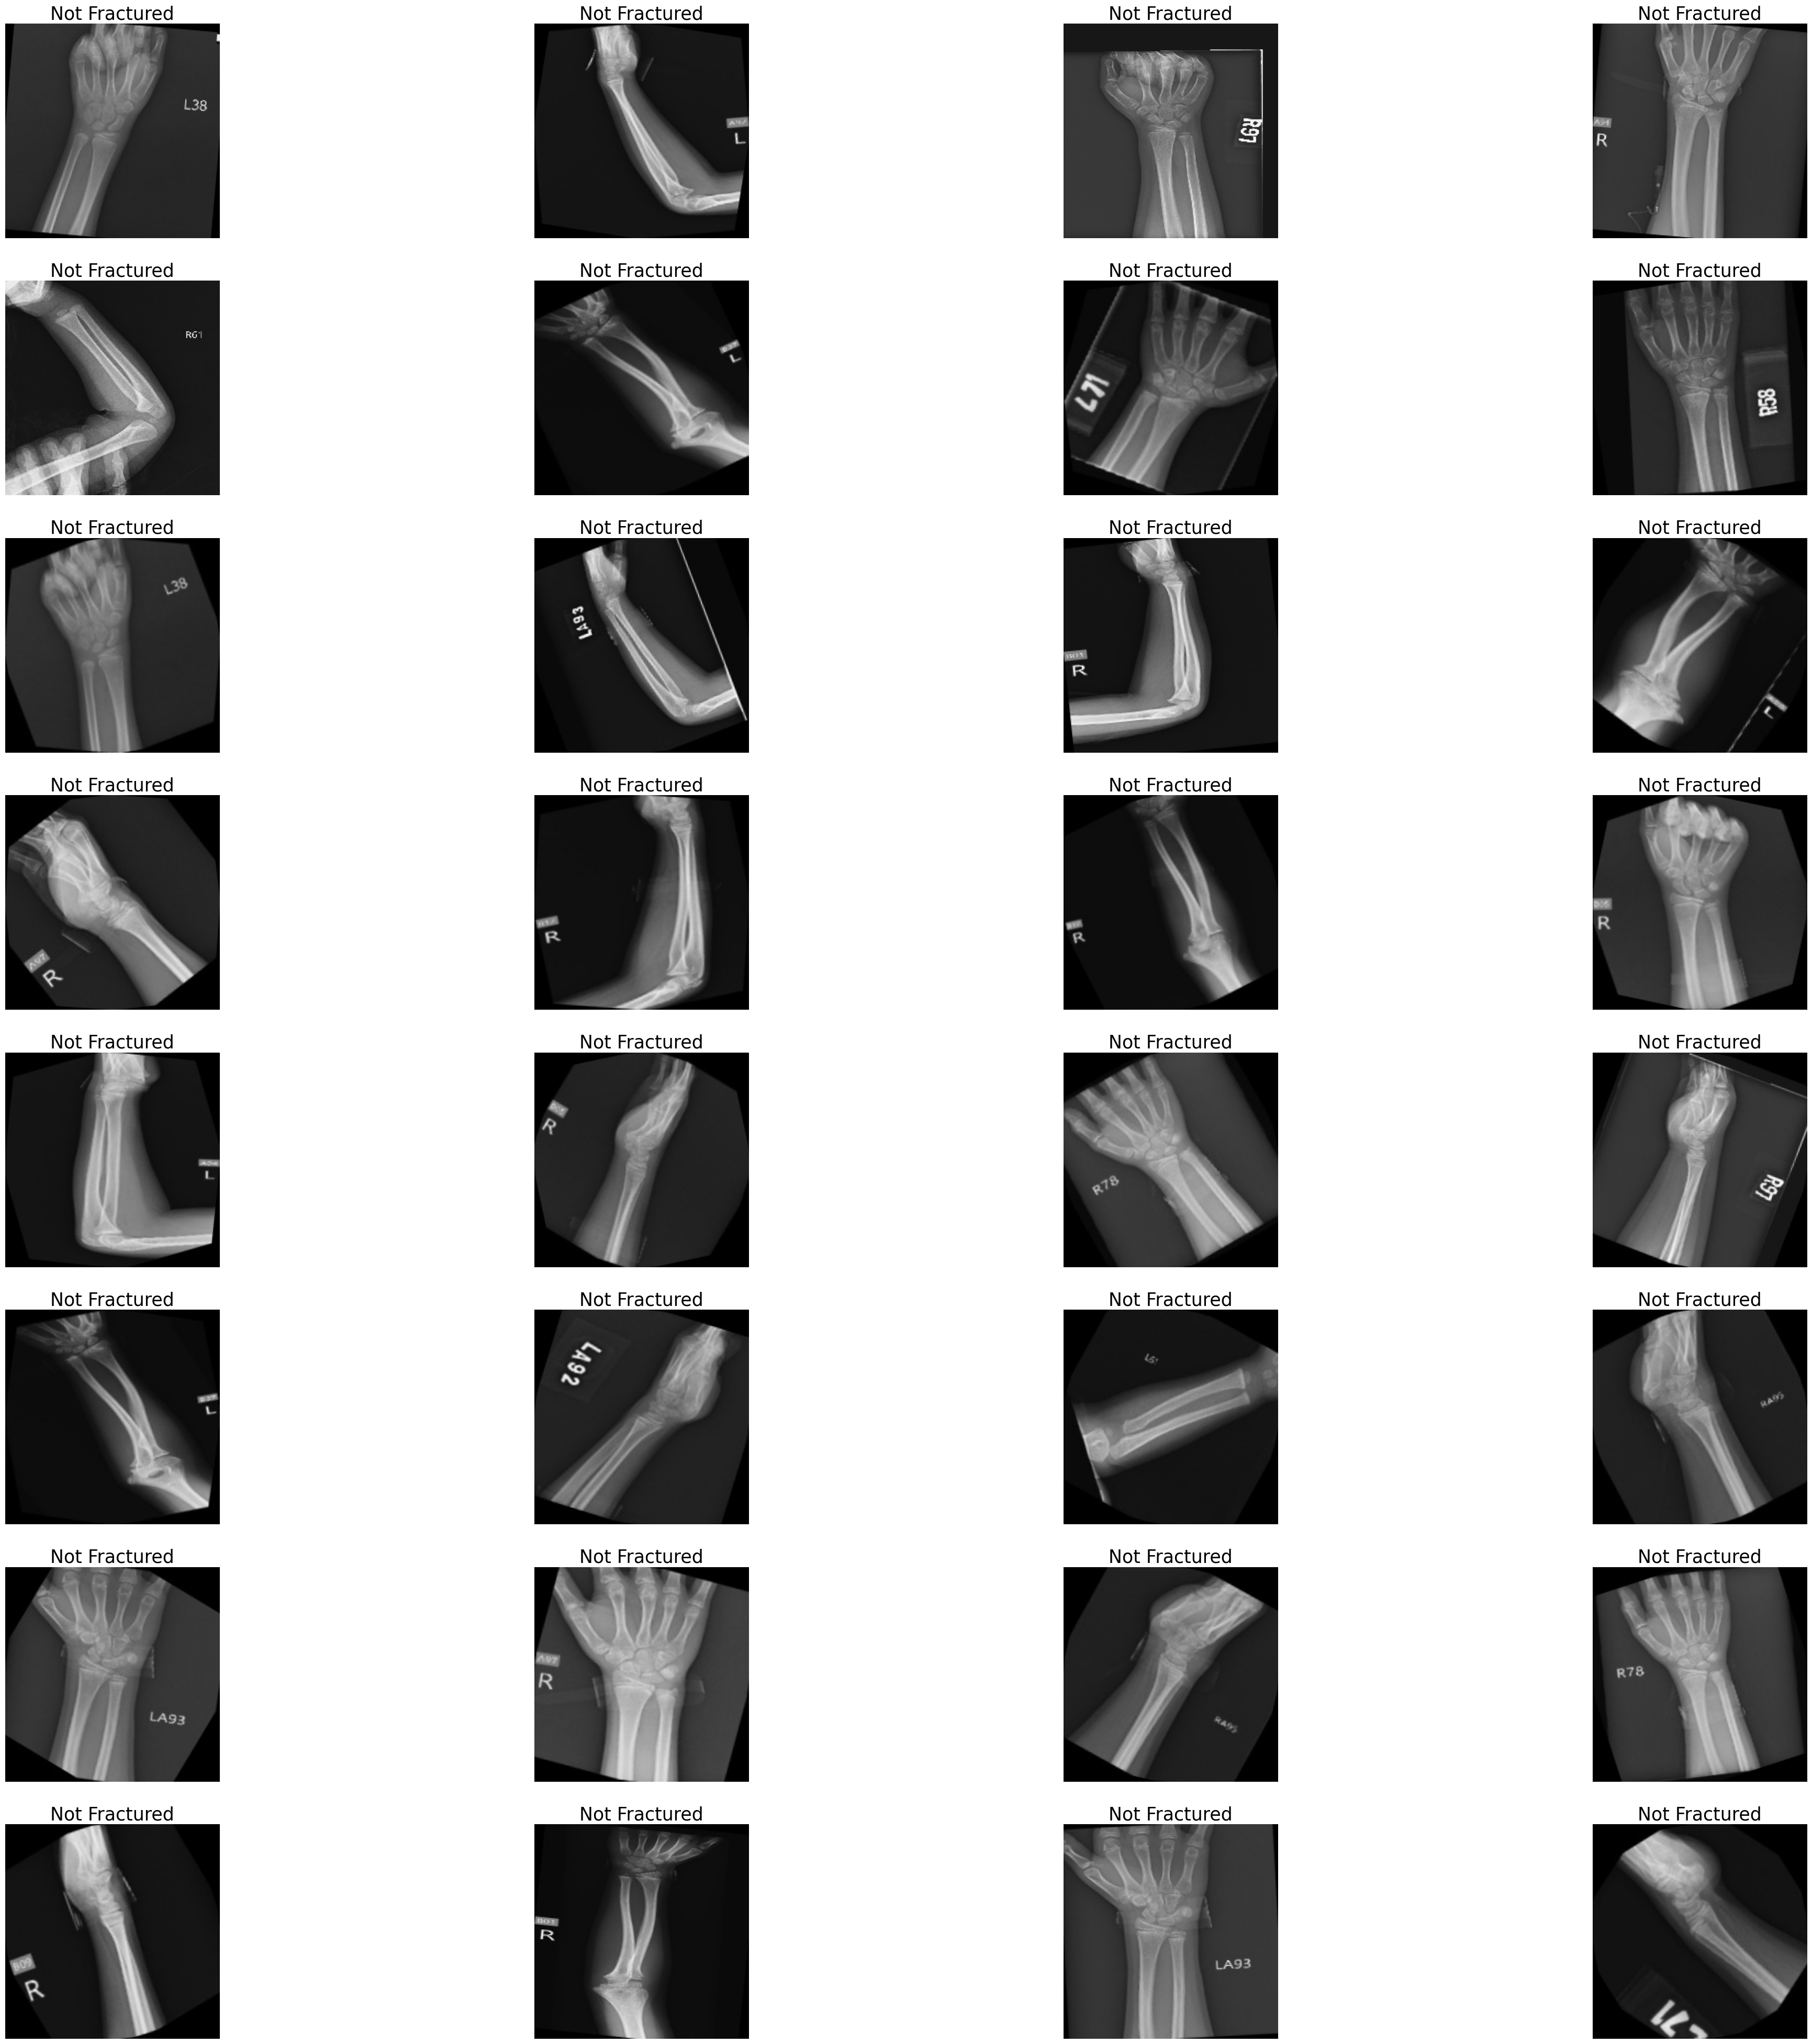

In [16]:
class_names=['Fractured', 'Not Fractured']
batch = next(test_generator)
images= batch[0]
plt.figure(figsize=(50,50))
for n in range(32):
    plt.subplot(8,4,n+1)
    plt.imshow(images[n])
    plt.axis('off')
    plt.title(class_names[int(y_test[n])],fontsize=25)

array([[196,   3],
       [ 17, 183]])

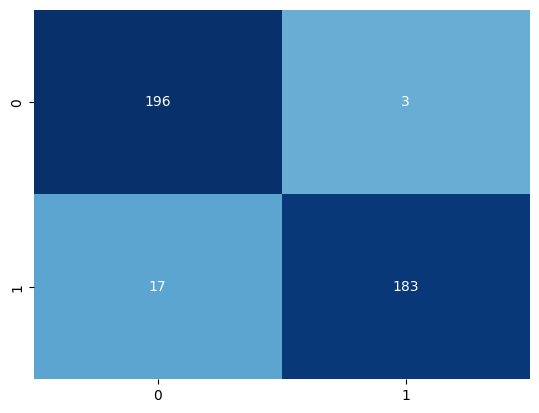

In [17]:
CM = confusion_matrix(y_test,y_pred)
sns.heatmap(CM,fmt='g',center = True,cbar=False,annot=True,cmap='Blues')
CM

In [18]:
ClassificationReport = classification_report(y_test,y_pred)
print('Classification Report is : ', ClassificationReport )

Classification Report is :                precision    recall  f1-score   support

           0       0.92      0.98      0.95       199
           1       0.98      0.92      0.95       200

    accuracy                           0.95       399
   macro avg       0.95      0.95      0.95       399
weighted avg       0.95      0.95      0.95       399

